# GEONE - GEOSCLASSIC - categorical variable - Examples in 3D - non-stationary covariance model

## Estimation (kriging) and simulation (Sequential Indicator Simulation, SIS)

See notebook `ex_geosclassic_indicator_1d_1.ipynb` for detail explanations about estimation (kriging) and simulation (Sequential Indicator Simulation, SIS) in a grid.

## Non-stationary covariance model over a grid
See notebook `ex_geosclassic_1d_2_non_stat_cov.ipynb` for detail explanations on how to set non-stationarities in a grid.

## Examples in 3D
In this notebook, examples in 3D with a non-stationary covariance model are given.



## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pyvista as pv
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


In [3]:
pv.set_jupyter_backend('static') # static plots
# pv.set_jupyter_backend('trame')  # 3D-interactive plots

### Remark
The matplotlib figures can be visualized in *interactive* mode:

- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Category values
A list of category values (facies) must be defined. Let `ncategory` be the length of this list, *i.e.* the number of categories:

- if `ncategory == 1`: the unique category value given must not be equal to 0; this is used for a binary case with values ("unique category value", 0), where 0 indicates the absence of the considered medium; conditioning data values should be "unique category value" or 0
- if `ncategory >= 2`: this is used for a multi-category case with given values (distinct); conditioning data values should be in the list of given values

Then, set color for each category, and color maps for proportions (for further plots).

**Below: select the case with `ncategory` greater than one or equal to one below, comment the undesired cell.**

In [4]:
# Case with ncategory > 1
# -----------------------
category_values = [1., 2., 3.]
ncategory = len(category_values)

# Set colors ...
categVal = category_values
categCol = ['tab:blue', 'orange', 'darkgreen'] # must be of length len(categVal)
cmap_categ = [gn.customcolors.custom_cmap(['white', c]) for c in categCol]
categActive = [False, True, True]



In [5]:
# # Case with ncategory = 1
# # -----------------------
# category_values = [2.] # all categories are 2. and 0.
# ncategory = len(category_values)

# # Set colors ...
# categVal = [category_values[0], 0]
# categCol = ['tab:red', 'lightblue'] # must be of length len(categVal)
# cmap_categ = [gn.customcolors.custom_cmap(['white', c]) for c in categCol]
# categActive = [True, False]


## Grid (3D)

In [6]:
nx, ny, nz = 85, 56, 34  # number of cells
sx, sy, sz = 1.0, 1.0, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

dimension = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (ox, oy, oz)

## Covariance model

In 3D, a covariance model is given by an instance of the class `geone.covModel.covModel3D` (or `geone.covModel.covModel1D` for omni-directional (isotropic) case).

### Base covariance model (sationary)
The angles are set to `0`, local rotation will be set further.

In [7]:
# Define the base covariance model (stationary)
cov_model = gn.covModel.CovModel3D(elem=[
    ('exponential', {'w':8.5, 'r':[10, 40, 10]}) # elementary contribution
    ], alpha=0, beta=0, gamma=0, name='model-3D example')

In [8]:
# pp = pv.Plotter()
# # pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
# cov_model.plot_model3d_volume(plotter=pp)
# pp.add_text('Covariance function - base')
# cpos = pp.show(cpos=(165, -100, 115), return_cpos=True)

### Defining non-stationarities


In [9]:
# Set an image with grid geometry defined above, and no variable
im = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Get the x, y, z coordinates of the centers of grid cell (meshgrid)
xx = im.xx()
yy = im.yy()
zz = im.zz()

# Set angles (alpha, beta, gamma) in degrees in the grid for further estimation/simulation
# ----------------------------------------------------------------------------------------
# Define angles over the grid
alpha = 90
beta = 0 + (xx-xx.min())/(xx.max()-xx.min())*90.
gamma = 0


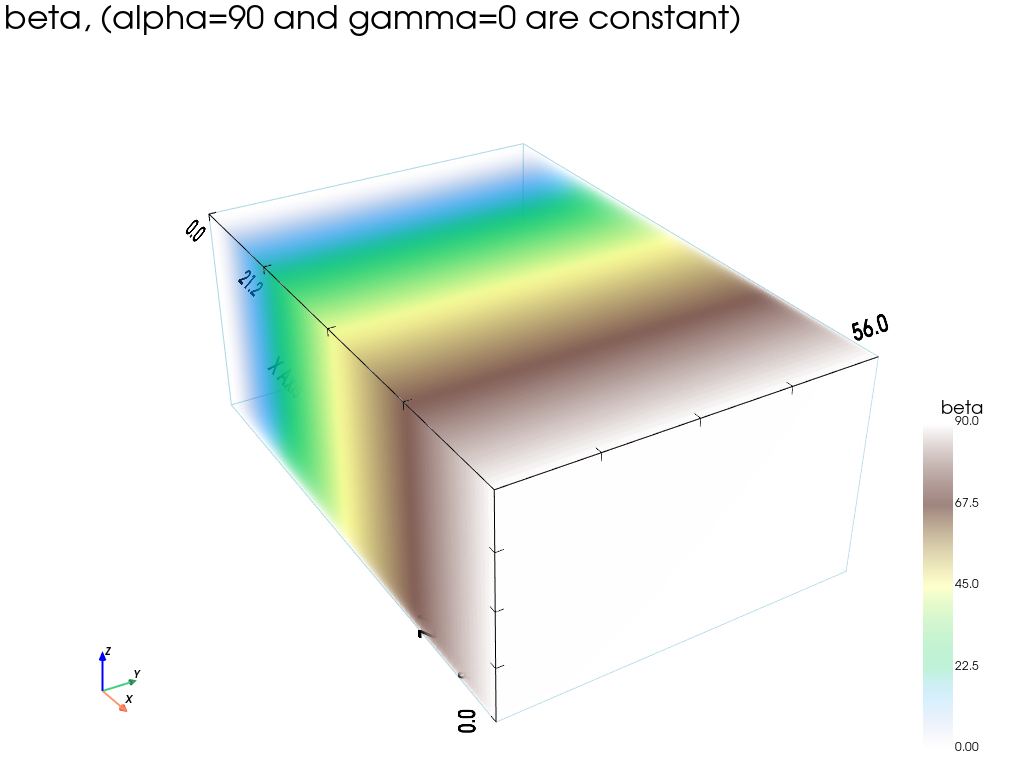

In [10]:
# Plot non-stationarities

# Set variable beta image im
im.append_var(beta, varname='beta')

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()

gn.imgplot3d.drawImage3D_volume(
    im, 
    plotter=pp,
    cmap='terrain',
    text=f'beta, (alpha={alpha} and gamma={gamma} are constant)',
    show_bounds=True,
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified


## 1. Example

### Settings - using data (optional) and probability (constant, optional)

In [11]:
if ncategory > 1:
    # Case with ncategory > 1
    # -----------------------
    # Data
    x = np.array([[ 10.25,  20.14,  3.15], 
                  [ 40.50,  10.50, 10.50], 
                  [ 30.65,  40.53, 20.24],
                  [ 30.18,  30.14, 30.98]]) # data locations (real coordinates)    
    v = [ 1., 2., 1., 3.]            # data values
    # x = None
    # v = None

    # Probability, proportion of each category
    probability = [.1, .2, .7] # should sum to 1
    # probability = None

    # Type of kriging
    method = 'simple_kriging'

else:
    # Case with ncategory = 1
    # -----------------------
    # Data
    x = np.array([[ 10.25,  20.14,  3.15], 
                  [ 40.50,  10.50, 10.50], 
                  [ 30.65,  40.53, 20.24],
                  [ 30.18,  30.14, 30.98]]) # data locations (real coordinates)    
    v = [ 0., 2., 2., 0.]           # data values
    # x = None
    # v = None

    # Probability, proportion (of non-zero category)
    probability = [.7] # list of one number in the interval [0, 1]
    # probability = None

    # Type of kriging
    method = 'simple_kriging'

### Estimation of probabilities (by kriging)

In [12]:
# Computational resources
nthreads = 8

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            alpha=alpha,                   # rotation...
                            beta=beta,
                            gamma=gamma,
                            method=method,                 # type of kriging
                            use_unique_neighborhood=False,  # search neighborhood ...
                            searchRadius=None,             
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nthreads=nthreads,              # computational resources
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image


estimateIndicator: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic run complete
estimateIndicator: Geos-Classic (1 process) run complete
Elapsed time: 68 sec


In [13]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [14]:
%%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Equivalent, using other computational resources
# -----------------------------------------------
# Computational resources
nthreads = 1

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            alpha=alpha,                   # rotation...
                            beta=beta,
                            gamma=gamma,
                            method=method,                 # type of kriging
                            use_unique_neighborhood=False,  # search neighborhood ...
                            searchRadius=None,             
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nthreads=nthreads,              # computational resources
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img_2 = geosclassic_output['image'] # output image

print(f"Same results ? {np.allclose(krig_img.val, krig_img_2.val)}")


### Simulations

In [15]:
# Number of realizations
nreal = 50

# Seed
seed = 321

# Computational resources
nproc = 2
nthreads_per_proc = 4

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            alpha=alpha,                   # rotation...
                            beta=beta,
                            gamma=gamma,
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulateIndicator: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim [pid=0]: Geos-Classic run complete
simulateIndicator: Geos-Classic (2 process(es)) run complete
Elapsed time: 34 sec


In [16]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [17]:
%%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Equivalent, using other computational resources
# -----------------------------------------------
# Computational resources
nproc = 1
nthreads_per_proc = 1

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            alpha=alpha,                   # rotation...
                            beta=beta,
                            gamma=gamma,
                            # method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img_2 = geosclassic_output['image'] # output image

print(f"Same results ? {np.allclose(simul_img.val, simul_img_2.val)}")


### Plot the results

In [18]:
# Compute proportion of each category (pixel-wise)
simul_img_prop = gn.img.imageCategProp(simul_img, category_values)

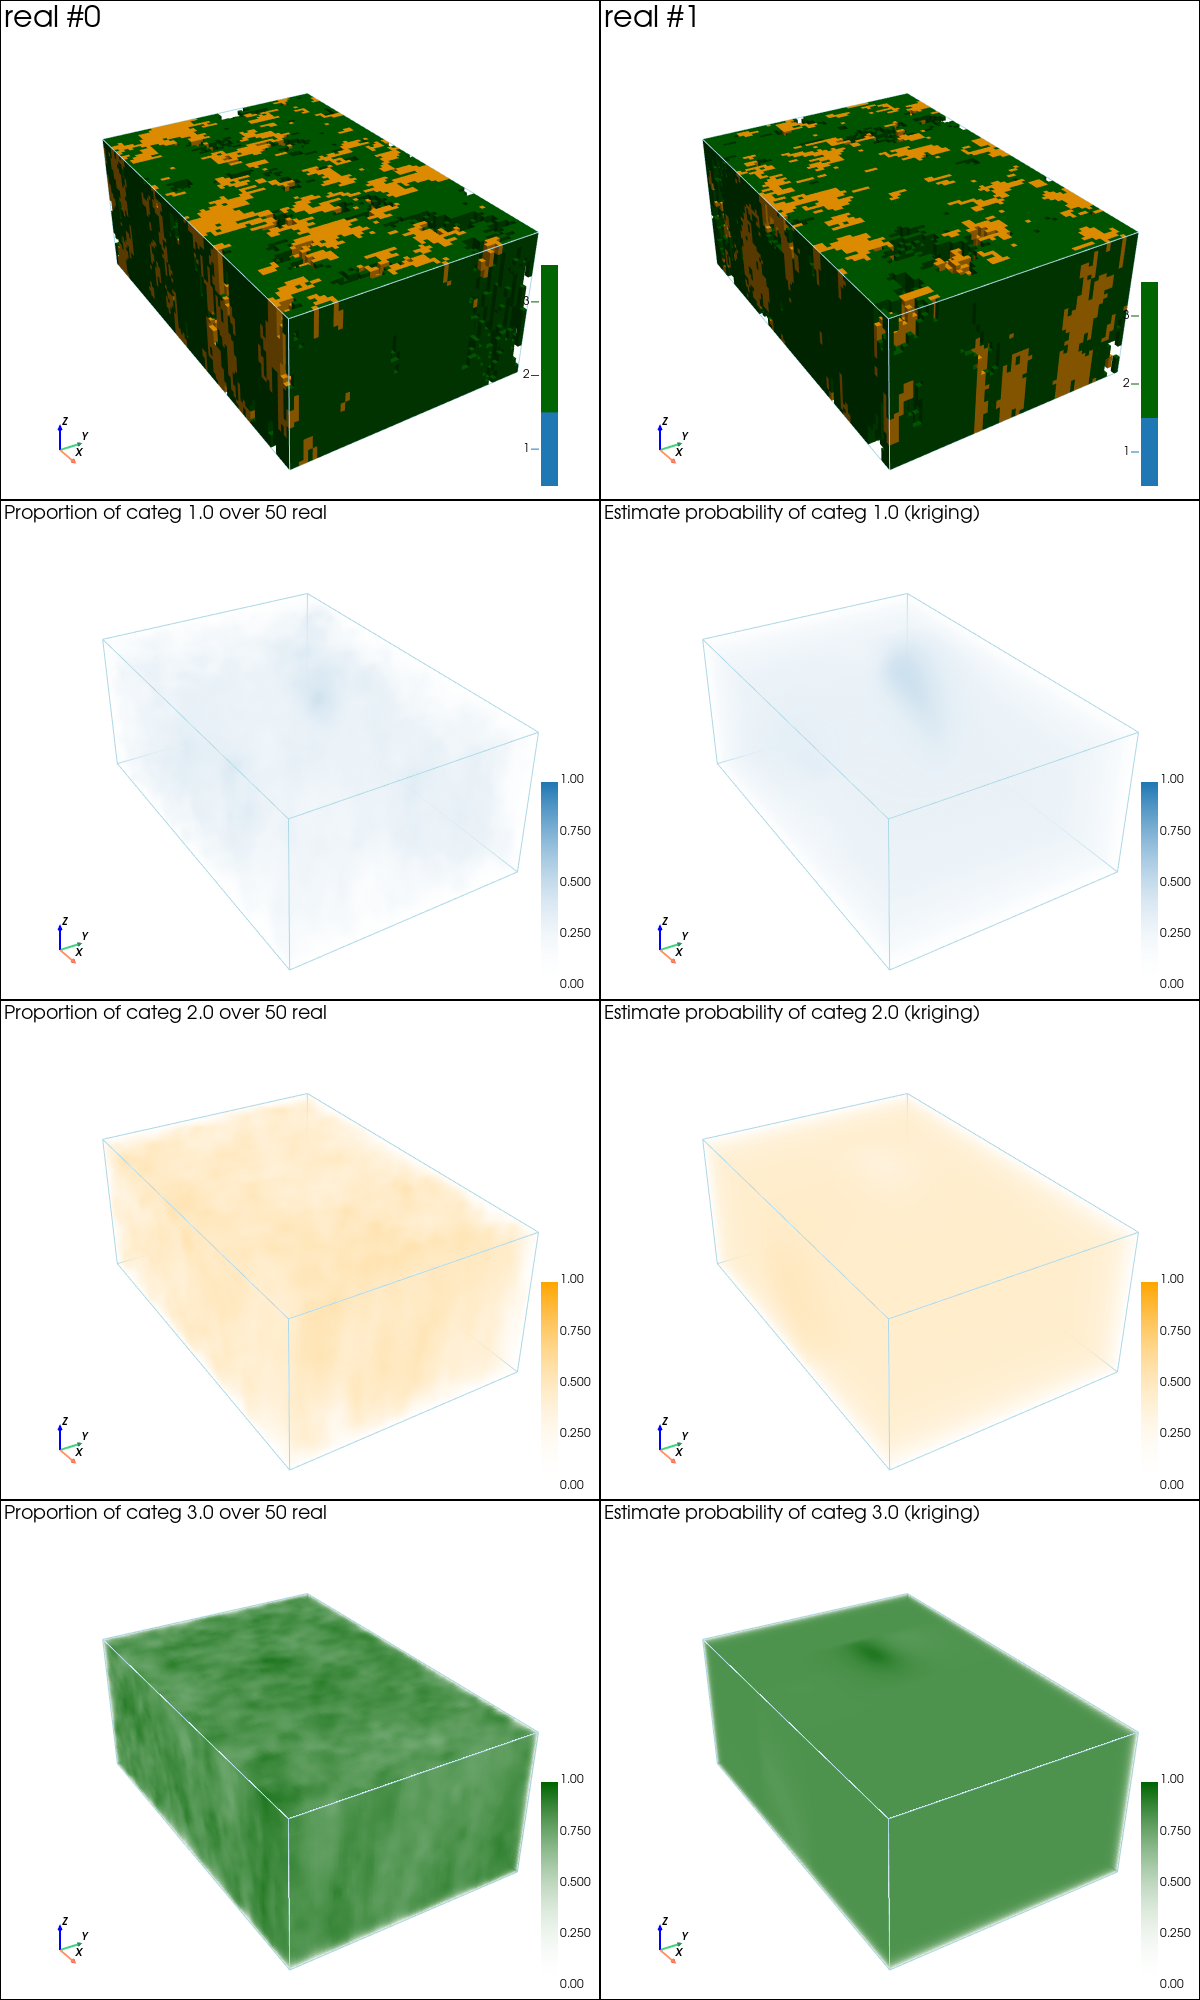

In [19]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1+ncategory, 2), window_size=(1200, 500*(1+ncategory)), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1+ncategory, 2), window_size=(1200, 500*(1+ncategory)))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_surface(
        simul_img, iv=i, 
        plotter=pp,
        categ=True, categVal=categVal, categCol=categCol,
        categActive=categActive,
        text=f'real #{i}',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...

# Proportion over realizations
for i in range(ncategory):
    pp.subplot(i+1, 0)
    gn.imgplot3d.drawImage3D_volume(
        simul_img_prop, iv=i,
        plotter=pp,
        cmap=cmap_categ[i], cmin=0.0, cmax=1.0,
        text=f'Proportion of categ {categVal[i]} over {nreal} real',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':(i+2)*' ', 'vertical':True, 'label_font_size':12})

# Estimate by kriging
for i in range(ncategory):
    pp.subplot(i+1, 1)
    gn.imgplot3d.drawImage3D_volume(
        krig_img, iv=i,
        plotter=pp,
        cmap=cmap_categ[i], cmin=0.0, cmax=1.0,
        text=f'Estimate probability of categ {categVal[i]} (kriging)',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':(i+2+ncategory)*' ', 'vertical':True, 'label_font_size':12})

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

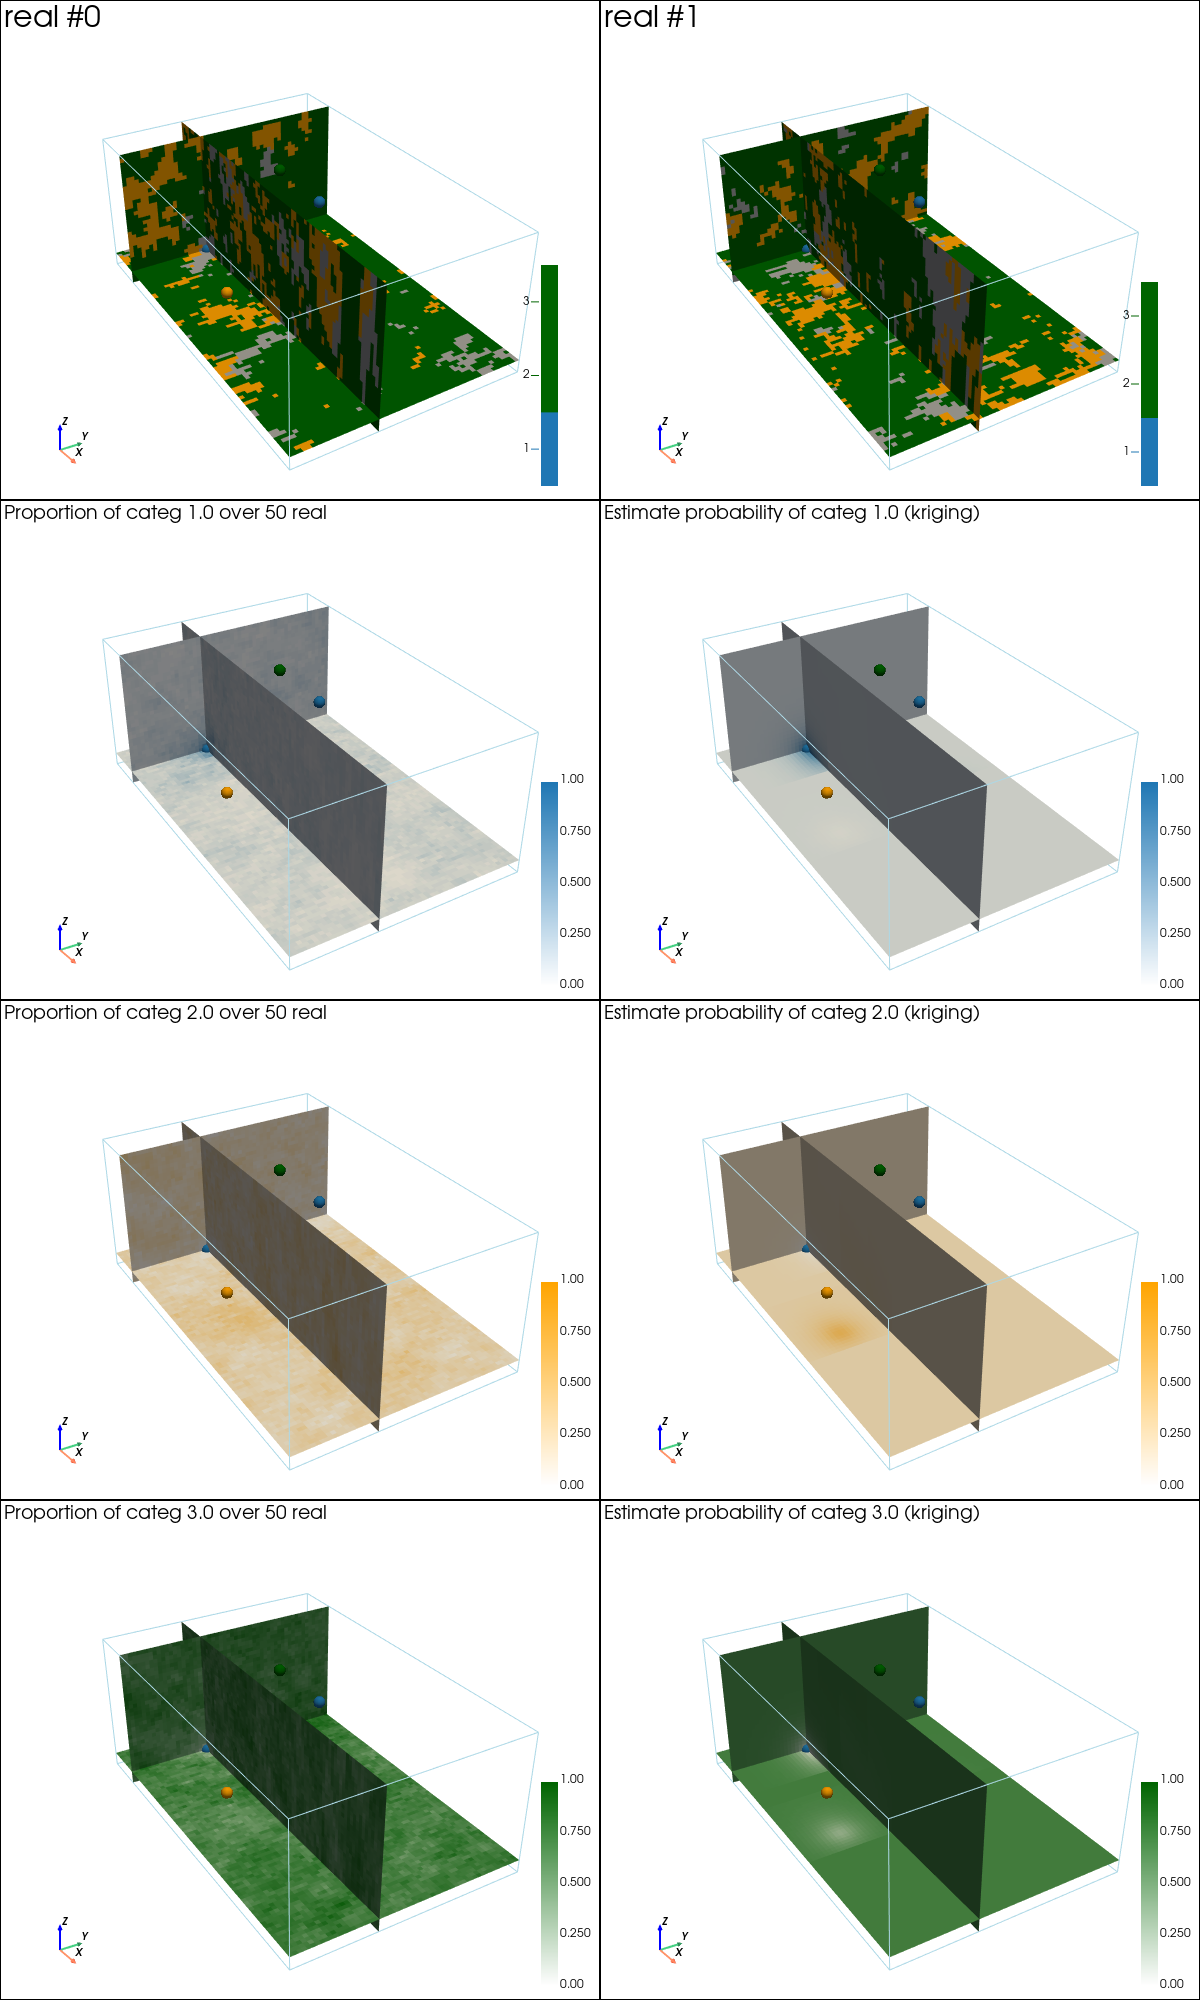

In [20]:
# Plot slices (with data points)
# ------------------------------

# Settings for plotting data
if x is not None:
    # Get index of color in categVal for conditioning data
    categVal_v = [np.where(vi == np.asarray(categVal))[0][0] for vi in v]
    
    
    # Get colors for conditioning data according to their value and color settings
    data_points_col      = np.asarray([matplotlib.colors.to_rgba(categCol[categVal_vi]) for categVal_vi in categVal_v])
    # data_points_mean_col = np.asarray([gn.imgplot.get_colors_from_values(1.0, cmap=cmap_categ[categVal_vi], cmin=0.0, cmax=1.0)[0] for categVal_vi in categVal_v])
    data_points_mean_col = data_points_col
    
    # Set points to be plotted
    data_points = pv.PolyData(x)
    data_points['colors'] = data_points_col

    data_points_mean = pv.PolyData(x)
    data_points_mean['colors'] = data_points_mean_col

    # Set slices through data of index j
    j = 0
    slice_normal_x = x[j,0]
    slice_normal_y = x[j,1]
    slice_normal_z = x[j,2]
else:
    # Set default slices
    slice_normal_x = simul_img.x()[int(0.2*nx)]
    slice_normal_y = simul_img.y()[int(0.8*ny)]
    slice_normal_z = simul_img.z()[int(0.2*nz)]

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1+ncategory, 2), window_size=(1200, 500*(1+ncategory)), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1+ncategory, 2), window_size=(1200, 500*(1+ncategory)))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_slice(
        simul_img, iv=i, 
        plotter=pp,
        slice_normal_x=slice_normal_x,
        slice_normal_y=slice_normal_y,
        slice_normal_z=slice_normal_z,
        categ=True, categVal=categVal, categCol=categCol,
        categActive=categActive,
        text=f'real #{i}',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# Proportion over realizations
for i in range(ncategory):
    pp.subplot(i+1, 0)
    gn.imgplot3d.drawImage3D_slice(
        simul_img_prop, iv=i,
        plotter=pp,
        slice_normal_x=slice_normal_x,
        slice_normal_y=slice_normal_y,
        slice_normal_z=slice_normal_z,
        cmap=cmap_categ[i], cmin=0.0, cmax=1.0,
        text=f'Proportion of categ {categVal[i]} over {nreal} real',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':(i+2)*' ', 'vertical':True, 'label_font_size':12})
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# Estimate by kriging
for i in range(ncategory):
    pp.subplot(i+1, 1)
    gn.imgplot3d.drawImage3D_slice(
        krig_img, iv=i,
        plotter=pp,
        slice_normal_x=slice_normal_x,
        slice_normal_y=slice_normal_y,
        slice_normal_z=slice_normal_z,
        cmap=cmap_categ[i], cmin=0.0, cmax=1.0,
        text=f'Estimate probability of categ {categVal[i]} (kriging)',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':(i+2+ncategory)*' ', 'vertical':True, 'label_font_size':12})
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified


### Check results

In [21]:
# Check data
# ----------
if x is not None:
    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], xk[2], sx, sy, sz, ox, oy, oz) for xk in x] # (ix, iy, iz) for each data point
    # Check estimation
    krig_v = [krig_img.val[:, iz, iy, ix] for ix, iy, iz in data_grid_index]
    if ncategory == 1:
        print(f'Estimation: all data respected ? {np.all(np.asarray(krig_v).reshape(-1) == np.asarray([1 if vi == category_values[0] else 0 for vi in v]))}')
    else:
        print(f'Estimation: all data respected ? {np.all([np.all(krig_v[i] == np.eye(ncategory)[np.where(np.asarray(category_values) == v[i])[0][0]]) for i in range(len(x))])}')
    # Check simulation
    sim_v = [simul_img.val[:, iz, iy, ix] for ix, iy, iz in data_grid_index]
    print(f'Simulation: all data respected ? {np.all([np.all(sim_v[i] == v[i]) for i in range(len(x))])}')


Estimation: all data respected ? True
Simulation: all data respected ? True


In [22]:
# Compare probabilities
# ---------------------
if probability is not None:
    print(f'Prescribed probabilities                                    = {probability}')
    print(f'Estimation: probabilities (mean over the grid)              = {krig_img.val.mean(axis=(1,2,3))}')
    print(f'Simulation: probabilities (mean over the grid and all real.)= {[np.mean(simul_img.val == cv) for cv in category_values]}')

Prescribed probabilities                                    = [0.1, 0.2, 0.7]
Estimation: probabilities (mean over the grid)              = [0.11270738 0.20270402 0.68458859]
Simulation: probabilities (mean over the grid and all real.)= [np.float64(0.09462024221453287), np.float64(0.21345143351458232), np.float64(0.6919283242708848)]


## 2. Example - using non-stationary probabilities

### Setting probability (proportion) maps

In [23]:
# Set an image with simulation grid geometry defined above, and no variable
im = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Get the x, y, z coordinates of the centers of grid cell (meshgrid)
xx = im.xx()
yy = im.yy()
zz = im.zz()

if ncategory > 1:
    # Case with ncategory > 1
    # -----------------------
    # Define probability maps for each category
    c = 0.9
    p1 = xx + yy + zz
    p1 = c * (p1 - np.min(p1))/ (np.max(p1) - np.min(p1))
    p2 = c - p1
    p0 = (1. - c) * np.ones_like(p1) # 1.0 - p1 - p2 # constant map (0.1)

    probability = np.array((p0, p1, p2))

else:
    # Case with ncategory = 1
    # -----------------------
    c = 1.0
    # Define probability map for non-zero category
    p1 = xx + yy + zz
    p1 = c * (p1 - np.min(p1))/ (np.max(p1) - np.min(p1))
    probability = p1


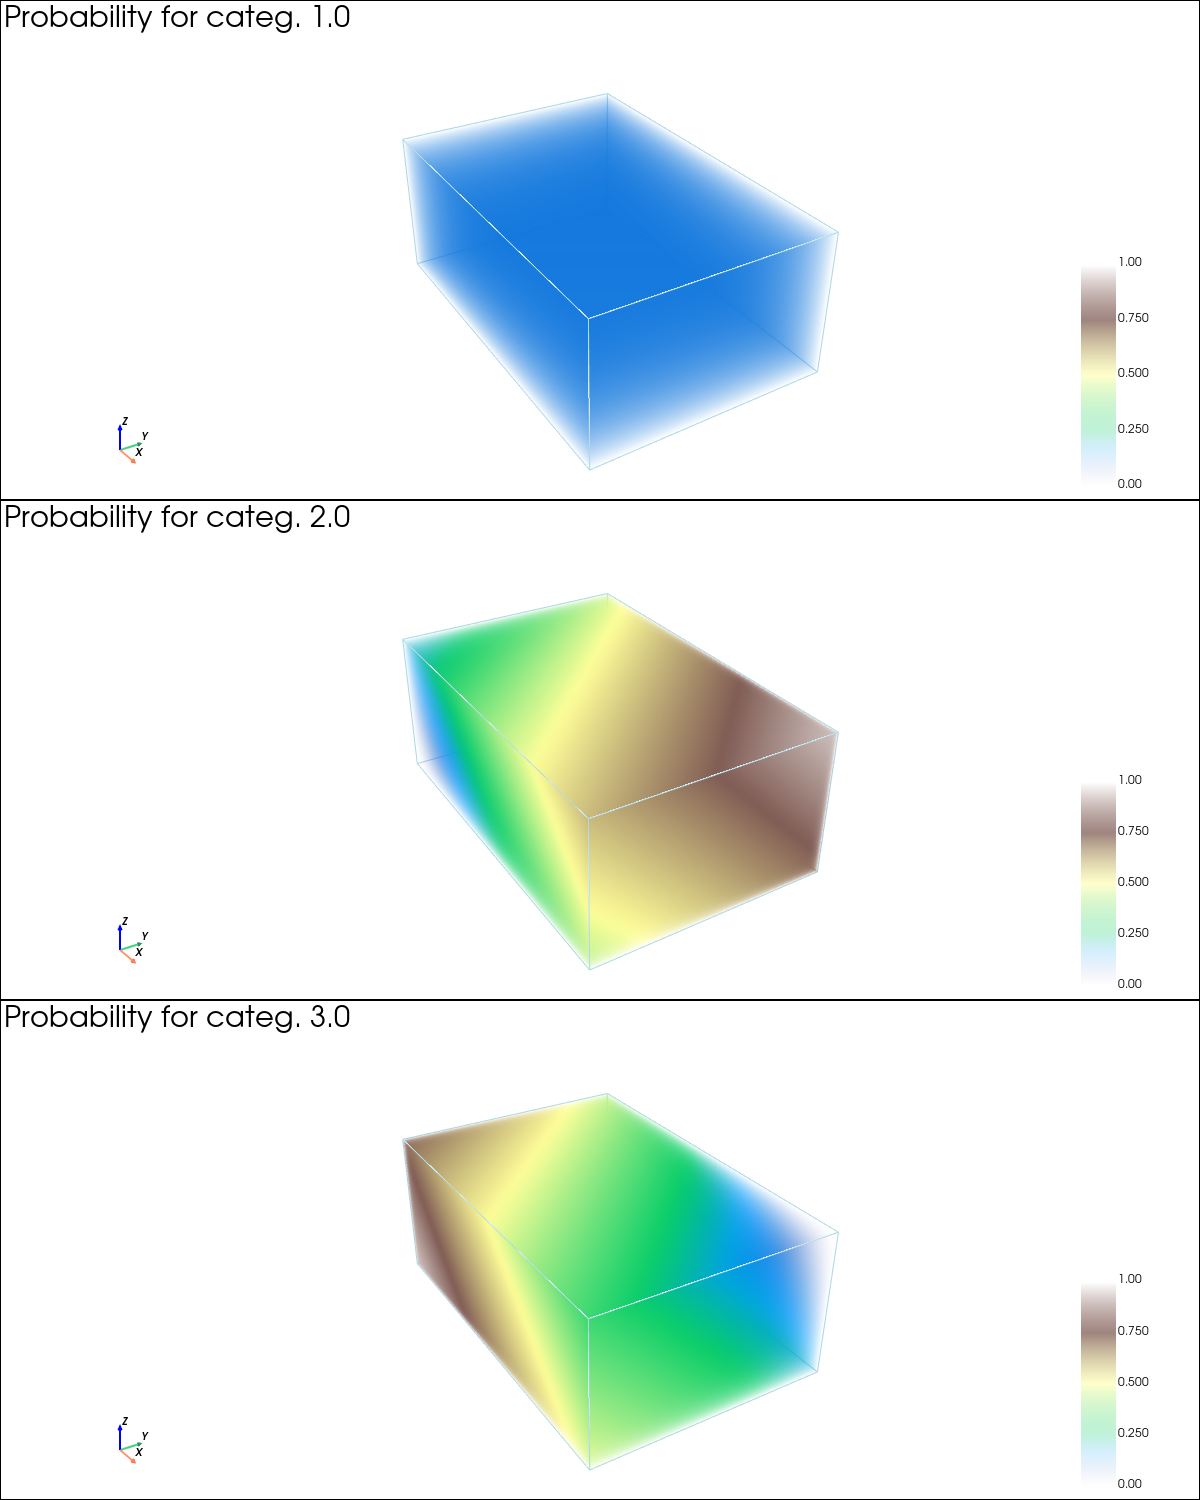

In [24]:
# Fill image for display
probability_img = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=ncategory, val=probability)

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(ncategory, 1), window_size=(1200, 500*(ncategory)), notebook=False)
# ... inline
pp = pv.Plotter(shape=(ncategory, 1), window_size=(1200, 500*(ncategory)))

for i in range(ncategory):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_volume(
        probability_img, iv=i,
        plotter=pp,
        cmap='terrain', cmin=0, cmax=1,
        text=f'Probability for categ. {categVal[i]}',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

### Settings - using data (optional)

In [25]:
if ncategory > 1:
    # Case with ncategory > 1
    # -----------------------
    # Data
    x = np.array([[ 10.25,  20.14,  3.15], 
                  [ 40.50,  10.50, 10.50], 
                  [ 30.65,  40.53, 20.24],
                  [ 30.18,  30.14, 30.98]]) # data locations (real coordinates)    
    v = [ 1., 2., 1., 3.]            # data values
    # x = None
    # v = None

    # Probability : `probability` defined above

    # Type of kriging
    method = 'simple_kriging'

else:
    # Case with ncategory = 1
    # -----------------------
    # Data
    x = np.array([[ 10.25,  20.14,  3.15], 
                  [ 40.50,  10.50, 10.50], 
                  [ 30.65,  40.53, 20.24],
                  [ 30.18,  30.14, 30.98]]) # data locations (real coordinates)    
    v = [ 0., 2., 2., 0.]           # data values
    # x = None
    # v = None

    # Probability : `probability` defined above

    # Type of kriging
    method = 'simple_kriging'

### Estimation of probabilities (by kriging)

In [26]:
# Computational resources
nthreads = 8

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            alpha=alpha,                   # rotation...
                            beta=beta,
                            gamma=gamma,
                            method=method,                 # type of kriging
                            use_unique_neighborhood=False,  # search neighborhood ...
                            searchRadius=None,             
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nthreads=nthreads,              # computational resources
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image


estimateIndicator: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic run complete
estimateIndicator: Geos-Classic (1 process) run complete
Elapsed time: 72 sec


In [27]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [28]:
%%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Equivalent, using other computational resources
# -----------------------------------------------
# Computational resources
nthreads = 1

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            alpha=alpha,                   # rotation...
                            beta=beta,
                            gamma=gamma,
                            method=method,                 # type of kriging
                            use_unique_neighborhood=False,  # search neighborhood ...
                            searchRadius=None,             
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nthreads=nthreads,              # computational resources
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img_2 = geosclassic_output['image'] # output image

print(f"Same results ? {np.allclose(krig_img.val, krig_img_2.val)}")


### Simulations

In [29]:
# Number of realizations
nreal = 50

# Seed
seed = 321

# Computational resources
nproc = 2
nthreads_per_proc = 4

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            alpha=alpha,                   # rotation...
                            beta=beta,
                            gamma=gamma,
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulateIndicator: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim [pid=0]: Geos-Classic run complete
simulateIndicator: Geos-Classic (2 process(es)) run complete
Elapsed time: 34 sec


In [30]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [31]:
%%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Equivalent, using other computational resources
# -----------------------------------------------
# Computational resources
nproc = 1
nthreads_per_proc = 1

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            alpha=alpha,                   # rotation...
                            beta=beta,
                            gamma=gamma,
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img_2 = geosclassic_output['image'] # output image

print(f"Same results ? {np.allclose(simul_img.val, simul_img_2.val)}")


### Plot the results

In [32]:
# Compute proportion of each category (pixel-wise)
simul_img_prop = gn.img.imageCategProp(simul_img, category_values)

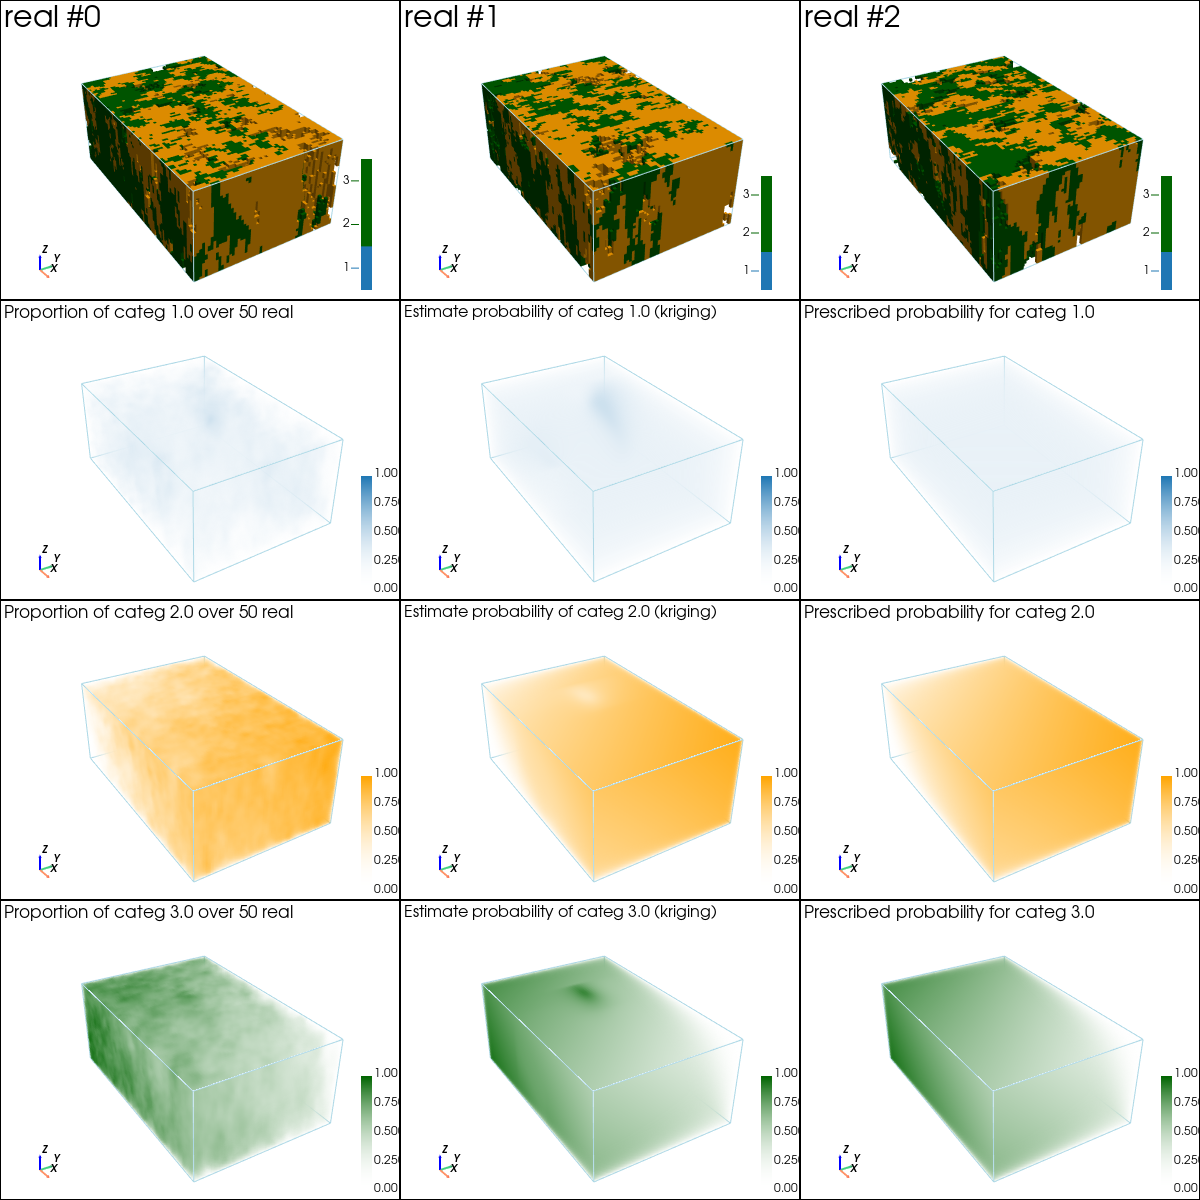

In [33]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1+ncategory, 2), window_size=(1200, 300*(1+ncategory)), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1+ncategory, 3), window_size=(1200, 300*(1+ncategory)))

# 3 first reals
for i in (0, 1, 2):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_surface(
        simul_img, iv=i, 
        plotter=pp,
        categ=True, categVal=categVal, categCol=categCol,
        categActive=categActive,
        text=f'real #{i}',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...

# Proportion over realizations
for i in range(ncategory):
    pp.subplot(i+1, 0)
    gn.imgplot3d.drawImage3D_volume(
        simul_img_prop, iv=i,
        plotter=pp,
        cmap=cmap_categ[i], cmin=0.0, cmax=1.0,
        text=f'Proportion of categ {categVal[i]} over {nreal} real',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':(i+3)*' ', 'vertical':True, 'label_font_size':12})

# Estimate by kriging
for i in range(ncategory):
    pp.subplot(i+1, 1)
    gn.imgplot3d.drawImage3D_volume(
        krig_img, iv=i,
        plotter=pp,
        cmap=cmap_categ[i], cmin=0.0, cmax=1.0,
        text=f'Estimate probability of categ {categVal[i]} (kriging)',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':(i+3+ncategory)*' ', 'vertical':True, 'label_font_size':12})

# Prescibed probability
for i in range(ncategory):
    pp.subplot(i+1, 2)
    gn.imgplot3d.drawImage3D_volume(
        probability_img, iv=i,
        plotter=pp,
        cmap=cmap_categ[i], cmin=0.0, cmax=1.0,
        text=f'Prescribed probability for categ {categVal[i]}',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':(i+3+2*ncategory)*' ', 'vertical':True, 'label_font_size':12})
pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

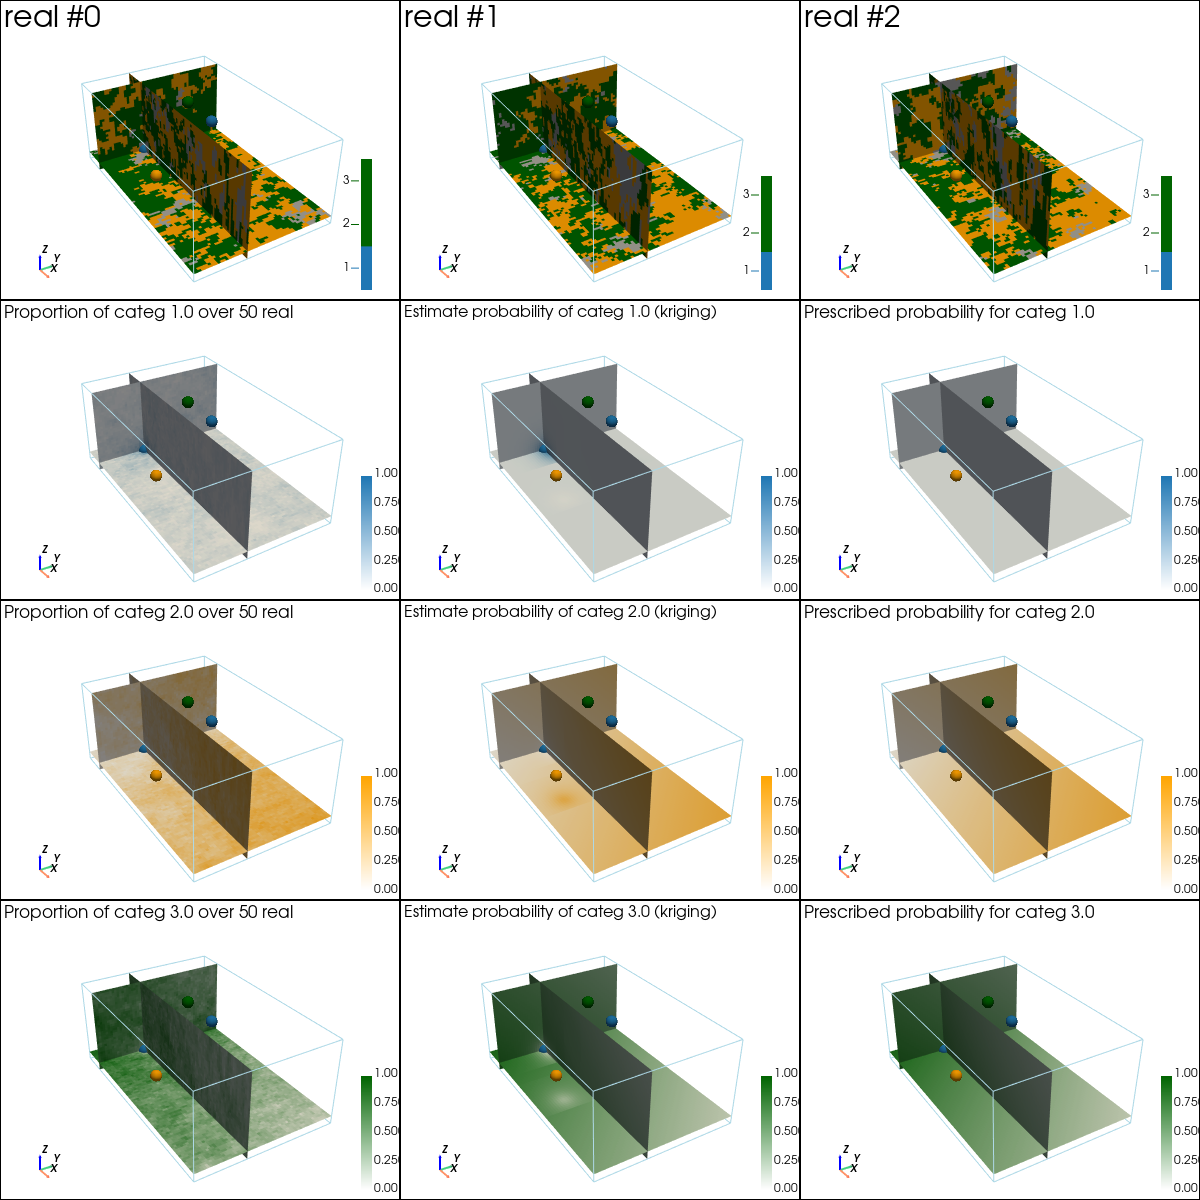

In [34]:
# Plot slices (with data points)
# ------------------------------

# Settings for plotting data
if x is not None:
    # Get index of color in categVal for conditioning data
    categVal_v = [np.where(vi == np.asarray(categVal))[0][0] for vi in v]
    
    
    # Get colors for conditioning data according to their value and color settings
    data_points_col      = np.asarray([matplotlib.colors.to_rgba(categCol[categVal_vi]) for categVal_vi in categVal_v])
    # data_points_mean_col = np.asarray([gn.imgplot.get_colors_from_values(1.0, cmap=cmap_categ[categVal_vi], cmin=0.0, cmax=1.0)[0] for categVal_vi in categVal_v])
    data_points_mean_col = data_points_col
    
    # Set points to be plotted
    data_points = pv.PolyData(x)
    data_points['colors'] = data_points_col

    data_points_mean = pv.PolyData(x)
    data_points_mean['colors'] = data_points_mean_col

    # Set slices through data of index j
    j = 0
    slice_normal_x = x[j,0]
    slice_normal_y = x[j,1]
    slice_normal_z = x[j,2]
else:
    # Set default slices
    slice_normal_x = simul_img.x()[int(0.2*nx)]
    slice_normal_y = simul_img.y()[int(0.2*ny)]
    slice_normal_z = simul_img.z()[int(0.2*nz)]

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1+ncategory, 2), window_size=(1200, 300*(1+ncategory)), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1+ncategory, 3), window_size=(1200, 300*(1+ncategory)))

# 3 first reals
for i in (0, 1, 2):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_slice(
        simul_img, iv=i, 
        plotter=pp,
        slice_normal_x=slice_normal_x,
        slice_normal_y=slice_normal_y,
        slice_normal_z=slice_normal_z,
        categ=True, categVal=categVal, categCol=categCol,
        categActive=categActive,
        text=f'real #{i}',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# Proportion over realizations
for i in range(ncategory):
    pp.subplot(i+1, 0)
    gn.imgplot3d.drawImage3D_slice(
        simul_img_prop, iv=i,
        plotter=pp,
        slice_normal_x=slice_normal_x,
        slice_normal_y=slice_normal_y,
        slice_normal_z=slice_normal_z,
        cmap=cmap_categ[i], cmin=0.0, cmax=1.0,
        text=f'Proportion of categ {categVal[i]} over {nreal} real',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':(i+3)*' ', 'vertical':True, 'label_font_size':12})
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# Estimate by kriging
for i in range(ncategory):
    pp.subplot(i+1, 1)
    gn.imgplot3d.drawImage3D_slice(
        krig_img, iv=i,
        plotter=pp,
        slice_normal_x=slice_normal_x,
        slice_normal_y=slice_normal_y,
        slice_normal_z=slice_normal_z,
        cmap=cmap_categ[i], cmin=0.0, cmax=1.0,
        text=f'Estimate probability of categ {categVal[i]} (kriging)',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':(i+3+ncategory)*' ', 'vertical':True, 'label_font_size':12})
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# Prescibed probability
for i in range(ncategory):
    pp.subplot(i+1, 2)
    gn.imgplot3d.drawImage3D_slice(
        probability_img, iv=i,
        plotter=pp,
        slice_normal_x=slice_normal_x,
        slice_normal_y=slice_normal_y,
        slice_normal_z=slice_normal_z,
        cmap=cmap_categ[i], cmin=0.0, cmax=1.0,
        text=f'Prescribed probability for categ {categVal[i]}',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':(i+3+2*ncategory)*' ', 'vertical':True, 'label_font_size':12})
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

### Check results

In [35]:
# Check data
# ----------
if x is not None:
    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], xk[2], sx, sy, sz, ox, oy, oz) for xk in x] # (ix, iy, iz) for each data point
    # Check estimation
    krig_v = [krig_img.val[:, iz, iy, ix] for ix, iy, iz in data_grid_index]
    if ncategory == 1:
        print(f'Estimation: all data respected ? {np.all(np.asarray(krig_v).reshape(-1) == np.asarray([1 if vi == category_values[0] else 0 for vi in v]))}')
    else:
        print(f'Estimation: all data respected ? {np.all([np.all(krig_v[i] == np.eye(ncategory)[np.where(np.asarray(category_values) == v[i])[0][0]]) for i in range(len(x))])}')
    # Check simulation
    sim_v = [simul_img.val[:, iz, iy, ix] for ix, iy, iz in data_grid_index]
    print(f'Simulation: all data respected ? {np.all([np.all(sim_v[i] == v[i]) for i in range(len(x))])}')


Estimation: all data respected ? True
Simulation: all data respected ? True
